<a href="https://colab.research.google.com/github/Karsten-Yan/ky_blood_cell_images_kaggle/blob/master/blood_cell_images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import os
import zipfile
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [5]:
#upload kaggle.json api file
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [6]:
!mkdir /root/.kaggle
!mv /content/kaggle.json /root/.kaggle
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d paultimothymooney/blood-cells

 97% 105M/108M [00:02<00:00, 39.5MB/s] 
100% 108M/108M [00:02<00:00, 47.8MB/s]


In [7]:
zip_ref = zipfile.ZipFile('blood-cells.zip', 'r')
zip_ref.extractall()
zip_ref.close()

In [8]:
train_datagen = ImageDataGenerator(
        rescale = 1./255.,
        #validation_split=0.2
    )

validation_datagen = ImageDataGenerator(
    rescale = 1.0/255.)

In [9]:
base_dir = '/content/dataset2-master/dataset2-master/images'

train_dir = os.path.join(base_dir, 'TRAIN')
validation_dir = os.path.join(base_dir, 'TEST')

# Directory with our training cat/dog pictures
train_eo_dir = os.path.join(train_dir, 'EOSINOPHIL')
train_lympho_dir = os.path.join(train_dir, 'LYMPHOCYTE')
train_mono_dir = os.path.join(train_dir, 'MONOCYTE')
train_neutro_dir = os.path.join(train_dir, 'NEUTROPHIL')

# Directory with our validation cat/dog pictures
test_eo_dir = os.path.join(validation_dir, 'EOSINOPHIL')
test_lympho_dir = os.path.join(validation_dir, 'LYMPHOCYTE')
test_mono_dir = os.path.join(validation_dir, 'MONOCYTE')
test_neutro_dir = os.path.join(validation_dir, 'NEUTROPHIL')


In [10]:
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=64,
                                                    class_mode='categorical',
                                                    target_size=(150, 150),
                                                    #subset="training"
                                                    ) 
val_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=64,
                                                    class_mode='categorical',
                                                    target_size=(150, 150),
                                                    subset="validation")   
validation_generator =  validation_datagen.flow_from_directory(validation_dir,
                                                         batch_size=64,
                                                         class_mode  = 'categorical',
                                                         target_size = (150, 150))

Found 9957 images belonging to 4 classes.
Found 0 images belonging to 4 classes.
Found 2487 images belonging to 4 classes.


In [11]:
tf.random.set_seed(
    42
)

In [12]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(), 
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer="l2"),
    #tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(4, activation='softmax') 
])

# Compile Model. 
from tensorflow.keras.optimizers import RMSprop
model.compile(optimizer=RMSprop(learning_rate = 0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 18496)             0

In [14]:
history = {}
# Train the Model
history["first_cnn"] = model.fit(train_generator,
                              epochs=50,
                              verbose=1,
                              validation_data=validation_generator,
                              )

Epoch 1/50
156/156 [==============================] - 20s 130ms/step - loss: 1.5391 - accuracy: 0.2466 - val_loss: 1.3917 - val_accuracy: 0.2569
Epoch 2/50
156/156 [==============================] - 20s 127ms/step - loss: 1.3905 - accuracy: 0.2733 - val_loss: 1.3134 - val_accuracy: 0.3687
Epoch 3/50
156/156 [==============================] - 20s 128ms/step - loss: 1.3311 - accuracy: 0.3919 - val_loss: 1.2200 - val_accuracy: 0.5159
Epoch 4/50
156/156 [==============================] - 20s 126ms/step - loss: 1.2277 - accuracy: 0.4791 - val_loss: 1.1744 - val_accuracy: 0.5235
Epoch 5/50
156/156 [==============================] - 20s 126ms/step - loss: 1.1410 - accuracy: 0.5257 - val_loss: 0.9773 - val_accuracy: 0.6385
Epoch 6/50
156/156 [==============================] - 19s 124ms/step - loss: 1.0658 - accuracy: 0.5744 - val_loss: 0.9157 - val_accuracy: 0.6478
Epoch 7/50
156/156 [==============================] - 19s 124ms/step - loss: 0.9998 - accuracy: 0.6118 - val_loss: 0.8432 - val_ac

In [15]:
def history_plotter(history_dict):
  import matplotlib.pyplot as plt
  from matplotlib.pyplot import cm
  color=iter(cm.Set1(np.linspace(0,1,len(history_dict))))
  fig, (ax1,ax2) = plt.subplots(1,2, figsize=(16,8))

  for name, history in history_dict.items():
    c=next(color)
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    ax1.plot(epochs, acc, '-',c=c ,label=name +' Training accuracy')
    ax1.plot(epochs, val_acc,'--', c=c, label=name +' Validation accuracy')
  
    ax2.plot(epochs, loss, '-',c=c, label=name + ' Training Loss')
    ax2.plot(epochs, val_loss, '--',c=c, label=name + ' Validation Loss')
    
  
  ax1.set_title('Training and validation accuracy')
  ax1.legend()

  ax2.set_title('Training and validation loss')
  ax2.legend()

  

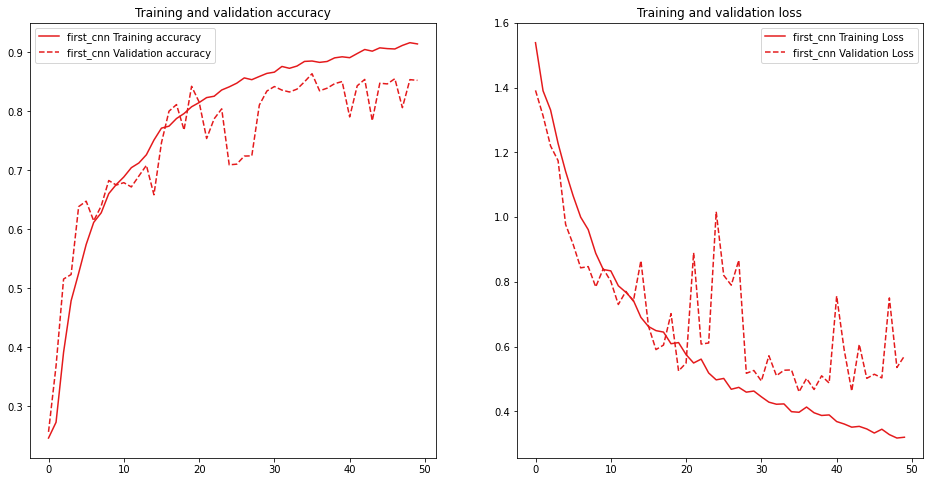

In [16]:
history_plotter(history)

In [19]:
model2 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(), 
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer="l2"),
    #tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(4, activation='softmax') 
])

# Compile Model. 
from tensorflow.keras.optimizers import RMSprop
model2.compile(optimizer=RMSprop(learning_rate = 0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [20]:
# Train the Model
history["second_cnn"] = model2.fit(train_generator,
                              epochs=50,
                              verbose=1,
                              validation_data=validation_generator,
                              )

Epoch 1/50
156/156 [==============================] - 20s 127ms/step - loss: 1.4403 - accuracy: 0.2538 - val_loss: 1.3945 - val_accuracy: 0.2686
Epoch 2/50
156/156 [==============================] - 20s 125ms/step - loss: 1.3927 - accuracy: 0.2965 - val_loss: 1.3724 - val_accuracy: 0.3193
Epoch 3/50
156/156 [==============================] - 20s 125ms/step - loss: 1.3920 - accuracy: 0.3195 - val_loss: 1.3911 - val_accuracy: 0.2963
Epoch 4/50
156/156 [==============================] - 20s 126ms/step - loss: 1.3493 - accuracy: 0.3722 - val_loss: 1.3308 - val_accuracy: 0.4479
Epoch 5/50
156/156 [==============================] - 20s 125ms/step - loss: 1.3007 - accuracy: 0.4254 - val_loss: 1.2126 - val_accuracy: 0.4664
Epoch 6/50
156/156 [==============================] - 19s 125ms/step - loss: 1.2078 - accuracy: 0.5022 - val_loss: 1.0667 - val_accuracy: 0.6084
Epoch 7/50
156/156 [==============================] - 20s 125ms/step - loss: 1.1069 - accuracy: 0.5723 - val_loss: 1.0337 - val_ac

In [1]:
history_plotter(history)

NameError: ignored